In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
imNum = 20
impath = 'trash_img'
#switching latex fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern",
    "text.latex.preamble": r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (16, 10)
})


# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error / 10 ** np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power // 3) >= 1:
        power = 3 * int(power // 3)
        value /= 10 ** power
        error /= 10 ** power
        digit_number = -first_digit_position + ndigits + power - 1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits - 1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov / np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size) * np.expand_dims(err, 1)
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(X, 1), *(
                np.expand_dims(popt, 1) + np.eye(popt.size) * np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1) * np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt) - nsigma * sigm_f, fun(domain, *popt) + nsigma * sigm_f)


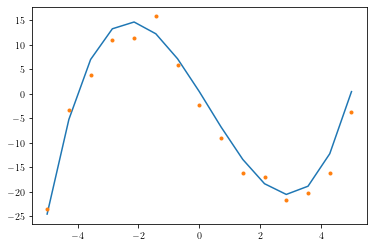

In [6]:
# data generation

def cub(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d
true_params = [0.5, -0.5, -10, 0.4]
x = np.linspace(-5, 5, 15)
error = 0.5
y = cub(x, *true_params)
noize = (np.random.normal(0, error, x.size))*np.mean(y)
y += noize
yerr=np.ones_like(x)*error*y.mean()
plt.plot(x, cub(x, *true_params)) 
plt.plot(x, y, '.') 

In [4]:
# maxA = cub(X, *popt)+10
# minA = cub(X, *popt)-10

0.5010810396443467 0.019967249321001905
-0.44637359943951826 0.053146456954851165
-10.223517862437305 0.370145638783023
0.4320603198871952 0.67705646671851


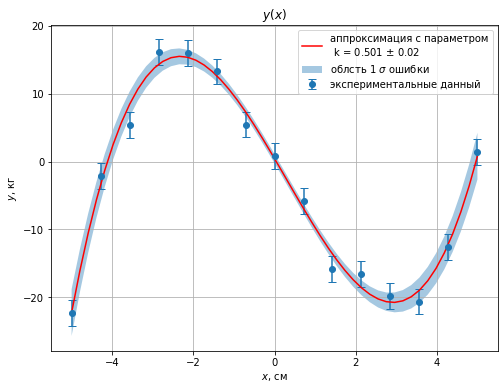

In [68]:
def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    return round(value, -first_digit_position + ndigits-1), round(error, -first_digit_position + ndigits-1)

# function to approximate
def f(x, k, b):
    return b + k * x
f = cub
teorPoints = 50     

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, x, y)
err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v, er)

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, fmt="o", yerr=error*y.mean(), label="экспериментальные данный", capsize=4, ms=6)
X = np.linspace(x.min(), x.max(), num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=
"аппроксимация с параметром\n k = {} $\pm$ {}".format(*err_pres_formatter(popt[0], err[0])))
nsigma = 1
plt.fill_between(X, *lower_upper_limits(X, f, popt, err, nsigma=nsigma), alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

# # плохой способ
# plt.fill_between(X, f(X, *(popt+err)), f(X, *(popt-err)), alpha=0.4)


plt.grid(True)
plt.xlabel(r"$x$, см")
plt.ylabel(r"$y$, кг")
plt.title(r"$y(x)$")
plt.legend()

plt.savefig(f"opt{i}.png", dpi=200)
i+=1

In [23]:
steps_number = 16
nsigma = 10
dev = np.zeros_like(popt)
allValues = np.zeros((steps_number**popt.size, X.size))

def iter_deviation(pars, errors, fun, par_index=0, deviation=None, i=0):
    if deviation is None:
        deviation = np.zeros_like(pars)
    if pars.size == par_index:
        allValues[i] = fun(X, *(popt+deviation))
        i+=1
    else:
        for deviation[par_index] in np.linspace(-errors[par_index]*nsigma,
        errors[par_index]*nsigma, steps_number):
            i = iter_deviation(pars, errors, fun, par_index=par_index+1, deviation=deviation, i=i)
    return i

print(iter_deviation(popt, err, f))
maxA = allValues.max(axis=0)
minA = allValues.min(axis=0)


65536


In [24]:
# X = np.expand_dims(X, axis=1)
deviations = np.eye(err.size)*err
print(deviations)

[[0.01996725 0.         0.         0.        ]
 [0.         0.05314646 0.         0.        ]
 [0.         0.         0.37014564 0.        ]
 [0.         0.         0.         0.67705647]]


In [42]:
a = f(np.expand_dims(X, axis=1), *(parameters.transpose()))


In [39]:
parameters.shape

(4, 4)

In [55]:
np.expand_dims(X, 1).shape

(50, 1)

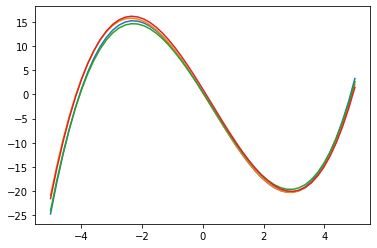

In [50]:
for i in range(a.shape[1]):
    plt.plot(X, a[:, i])

In [61]:
(domain, fun, popt, err) = X, f, popt, err
nsigma=1
deviations = np.eye(popt.size)*np.expand_dims(err, 1)
df = np.expand_dims(f(domain, *popt), 1) - f(np.expand_dims(X, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
sigm_f = np.sqrt(np.sum(df**2, 1))

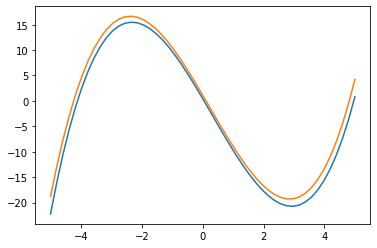

In [70]:
plt.plot(domain, f(domain, *popt))
plt.plot(domain, f(domain, *popt)+sigm_f)

0.4645911549185614 +- 0.03271444465104221
-0.5125758218844928 +- 0.08707542731961707
-9.676375683790999 +- 0.6064485243008486
-0.8252099274420309 +- 1.1092927553375471


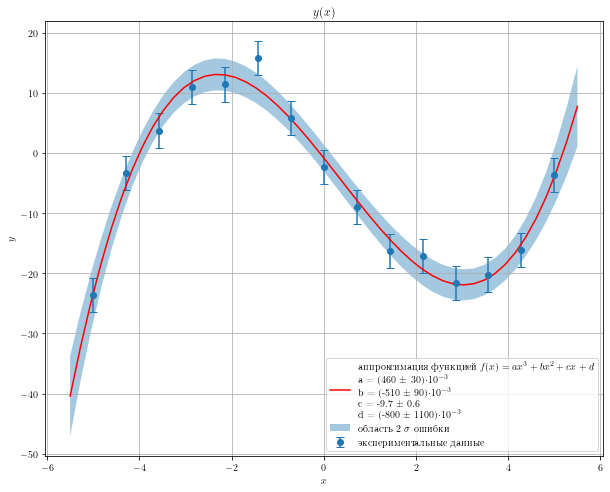

In [16]:
#xi square approximation with Y-errors
%matplotlib inline
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название осей с размерностями,
нагвание графика,
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
par_names = r'''
a,
b,
c,
d,
'''
# function to approximate
fun_name = "$f(x) = ax^3 + bx^2 + cx + d$"
f = cub
# конец пользовательских параметров

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
par_names = [x.split(',') for x in par_names.strip().split("\n")]
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"


plt.figure(figsize=(10, 8))
plt.errorbar(x, y, fmt="o", yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)
teorPoints = 50
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if visApproxError:
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

plt.grid(True)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$y(x)$")
plt.legend()

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

In [ ]:
"a,".split(',')